# TCC PUC AirBnB - Fabio Rafael Ladislei de Souza
Puc Minas Virtual

Notebook com o modelo preditivo de regressão para indicar os anúncios de hospedagem com o melhor custo-benefício do AirBnB, dada uma determinada localização e data.

## Bibliotecas Utilizadas

In [1]:
# https://pypi.org/project/pandas/
import pandas as pd

# https://numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt

# https://seaborn.pydata.org/
import seaborn as sns

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# https://docs.python.org/3/library/math.html
from math import sqrt

## Funções

In [2]:
# Realiza um pré-processamento básico no dataframe.
def preparar_dataset(df_pre):

    # Remove os atributos com baixa correlação com o alvo (price).
    df_pre.drop(['id'],axis=1,inplace=True)
    df_pre.drop(['host_name','amenities'],axis=1,inplace=True)
    df_pre.drop(['zipcode','latitude','longitude'],axis=1,inplace=True)

    # Converte os atributos categóricos em quantitativos discretos.
    for column in df_pre.columns:
        if str(df_pre[column].dtype) not in ['float64', 'int64']:
            df_pre[column] = df_pre[column].map \
            (dict(zip(df_pre[column].unique().tolist(),range(len(df_pre[column].unique().tolist())))))

    return df_pre

In [3]:
# Calcula métricas de desempenho do regressor.
def get_metrics(y_test, y_pred):  

    rmse = round(sqrt(mean_squared_error(y_test, y_pred)),4)
    r2 = round(r2_score(y_test, y_pred),4)

    return rmse, r2

## Inicialização

In [4]:
# Semente aleatória a ser usada ao longo desse notebook.
random_state=660601

# Nome do arquivo com os dados rotulados para treino.
nome_arquivo_com_rotulos_para_treino = 'treino.csv'

# Nome do arquivo com os dados não rotulados, que deverão ser analisados pelo modelo construído aqui.
nome_arquivo_sem_rotulos = 'teste.csv'

# Nome do arquivo que será criado com os rótulos gerados pelo modelo
# Esse é o arquivo se será submetido, contendo os resultados.
nome_arquivo_rotulado_regressor = 'submissao.csv'

## Carregando os dados rotulados

Nessa etapa carregamos os dados rotulados. Eles serão usados para treinamento de um modelo de regressão.

In [5]:
df = pd.read_csv(nome_arquivo_com_rotulos_para_treino, index_col=None, engine='python', sep =';', encoding="utf-8")
print('Total de registros carregados:',len(df))

# Exibe uma amostra dos dados.
df.head()

Total de registros carregados: 18661


,id,host_name,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,zipcode,latitude,longitude,...,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count
0,29727,brux,within an hour,100.0,t,f,ipanema,22420-020,-22.98333,-43.20161,...,3,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,7
1,13336,rosane,ND,0.0,f,f,ND,22760,-22.94213,-43.34465,...,0,0.0,0.0,0.0,0.0,0.0,0.0,f,flexible,1
2,22192,marco,within a few hours,100.0,f,f,ipanema,22081,-22.98651,-43.19221,...,1,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,3
3,25264,fatima,within an hour,100.0,t,t,copacabana,22031-112,-22.96407,-43.18687,...,0,0.0,0.0,0.0,0.0,0.0,0.0,f,strict_14_with_grace_period,5
4,23936,giovanni,within a few hours,87.0,f,f,leme,22010-070,-22.96326,-43.17065,...,1,0.0,0.0,0.0,0.0,0.0,0.0,f,strict_14_with_grace_period,37


## Preparando os dados para a predição

A preparação dos dados é uma das etapas mais importantes para se obter uma boa performance na modelagem preditiva, e pode significar a diferença entre o sucesso e o fracasso de um projeto.

In [6]:
df = preparar_dataset(df)
df.head()

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count
0,0,100.0,0,0,0,0,0,2,1.0,1.0,...,3,10.0,10.0,10.0,10.0,10.0,10.0,0,0,7
1,1,0.0,1,0,1,1,1,2,2.0,1.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,2,100.0,1,0,0,0,0,3,1.0,0.0,...,1,10.0,10.0,10.0,10.0,10.0,10.0,0,0,3
3,0,100.0,0,1,2,2,1,1,1.0,1.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5
4,2,87.0,1,0,3,1,0,4,1.0,2.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,37


## Analisando a correlação entre os atributos
Nessa etapa, vamos analisar a correlação entre os atributos, principalmente em relação ao preço. A correlação permite identificar variações proporcionais ou inversamente proporcionais entre duas variáveis, e se essas variação é forte ou fraca. Quanto maior a correlação, direta ou inversa, maior é a influência que esse atributo exerce na predição da outra, ou seja, do atributo alvo.

&lt;matplotlib.axes._subplots.AxesSubplot at 0x29d6f304b80&gt;

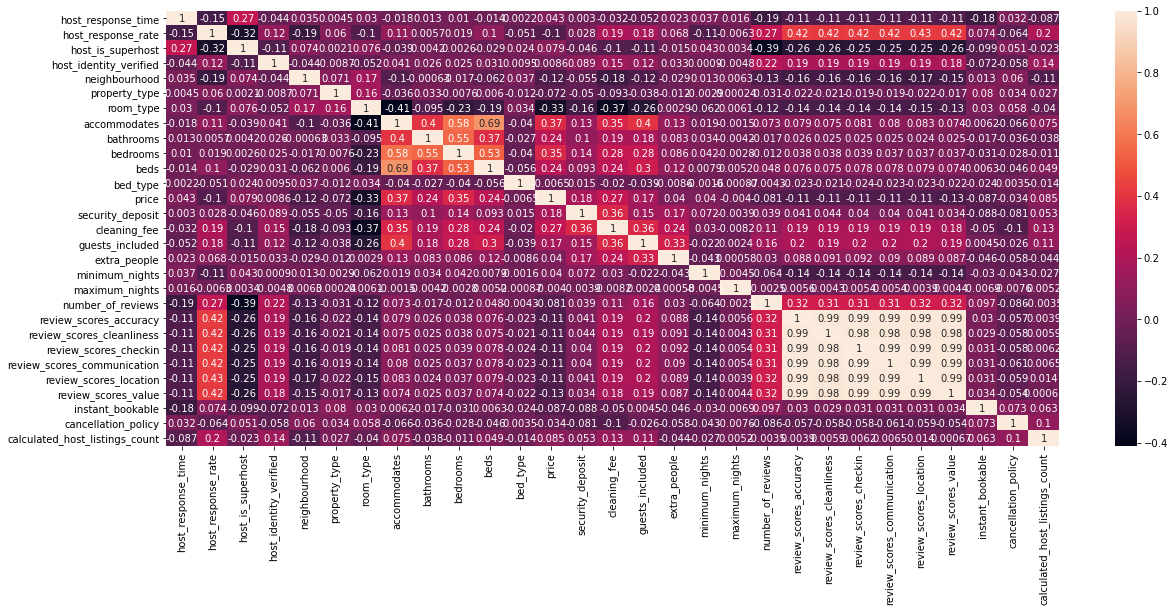

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(20,8))
sns.heatmap(corr,annot=True)

In [8]:
corr.sort_values(by = ['price'], ascending = False, inplace = True)
corr['price']

price                             1.000000
accommodates                      0.366104
bedrooms                          0.351309
cleaning_fee                      0.272182
beds                              0.236447
bathrooms                         0.236090
security_deposit                  0.183509
guests_included                   0.172975
calculated_host_listings_count    0.085445
host_is_superhost                 0.078678
host_response_time                0.042824
minimum_nights                    0.039900
extra_people                      0.039523
host_identity_verified            0.008590
maximum_nights                   -0.004001
bed_type                         -0.006531
cancellation_policy              -0.034101
property_type                    -0.072485
number_of_reviews                -0.080606
instant_bookable                 -0.087500
host_response_rate               -0.104218
review_scores_location           -0.108532
review_scores_cleanliness        -0.110553
review_scor

## Separando os dados

Nesta etapa, faremos a divisão dos dados entre: treino e teste. Essa divisão é necessária para as próximas etapas do aprendizado de máquina. Primeiro, iremos disponibilizar os dados de treino ao modelo para que aprenda as características dos dados que lhe forem apresentados. Então, disponibilizaremos os dados de teste, para que ele realize as predições com base nos dados apresentados anteriormente.

In [10]:
# Vamos dividir da seguinte forma: 80% para treino, 20% para teste. 
# Os registros deverão ser embaralhados.
df_train, df_test = train_test_split(df, test_size=0.20, shuffle=True, random_state=random_state)
X_train = pd.DataFrame(df_train.drop(['price'],axis=1))
y_train = pd.DataFrame(df_train['price'])
X_test = pd.DataFrame(df_test.drop(['price'],axis=1))
y_test = pd.DataFrame(df_test['price'])
print('Tamanho do Treino:',len(df_train),'- Tamanho do Teste:',len(df_test))

Tamanho do Treino: 14928 - Tamanho do Teste: 3733


## Escolhendo um modelo preditivo

Nesta etapa, faremos uma série de pesquisas e validações para encontrar o melhor algorítmo e suas melhores configurações, que correspondam às predições com maior acurácia para os dados fornecidos. Utilizaremos vários algoritmos, cada um com diversas configurações, numa pesquisa em Grid, utilizando também técnicas de validação cruzada. Tudo isso permitirá que encontremos um bom conjunto de algoritmo/configurações para realizarmos as predições que desejamos com o nosso modelo de regressão.

In [9]:
# criando lista de modelos preditivos a serem comparados - Primeira Rodada
# mapeando os nomes dos parâmetros dos modelos aos valores a serem verificados

models = []

from sklearn.linear_model import LinearRegression
param_grid_0 = {}
param_grid_1 = {'fit_intercept':[True,False],'normalize':[True,False]}
models.append(('LinearRegression', LinearRegression(), param_grid_0, param_grid_1))

from sklearn.linear_model import Ridge
param_grid_0 = {}
param_grid_1 = {'alpha':[0.01, 10, 1000],'normalize':[True,False],'copy_X':[True,False]
                , 'fit_intercept':[True,False], 'max_iter':[None], 'normalize':[True,False]
                , 'random_state':[None,0], 'solver':['auto'], 'tol':[0.001]}
models.append(('Ridge', Ridge(), param_grid_0, param_grid_1))

from sklearn.svm import SVR
param_grid_0 = {}
param_grid_1 = {'kernel':['linear', 'rbf'], 'gamma': [0.001, 0.1, 1, 10],'C': [0.001, 0.1, 1, 10]
                , 'epsilon': [x/100 for x in range(100,201,10)]}
models.append(('SVR', SVR(), param_grid_0, param_grid_1))

from sklearn.ensemble import RandomForestRegressor
param_grid_0 = {}
param_grid_1 = {'max_depth':range(1,4), 'random_state':[None, 0]
                , 'n_estimators':range(50,151,50),'bootstrap' :[True,False]}
models.append(('RandomForestRegressor', RandomForestRegressor(), param_grid_0, param_grid_1))

from sklearn.ensemble import GradientBoostingRegressor
param_grid_0 = {}
param_grid_1 = {'n_estimators':range(60,201,40), 'max_depth':range(1,5,2)
                , 'learning_rate':[x/100 for x in range(10,101,20)]}
models.append(('GradientBoostingRegressor', GradientBoostingRegressor(), param_grid_0, param_grid_1))

from sklearn.neighbors import KNeighborsRegressor
param_grid_0 = {}
param_grid_1 = {'n_neighbors':[3, 5, 7],'weights':['uniform','distance'],'p':[1,2]  }
models.append(('KNeighborsRegressor', KNeighborsRegressor(), param_grid_0, param_grid_1))

from sklearn.tree import DecisionTreeRegressor
param_grid_0 = {}
param_grid_1 = {'max_depth':[None, 1, 2, 3, 4, 5, 6],'splitter':['best','random']
                ,'presort':[True,False]}
models.append(('DecisionTreeRegressor', DecisionTreeRegressor(), param_grid_0, param_grid_1))

from sklearn.linear_model import Lasso
param_grid_0 = {}
param_grid_1 = {'fit_intercept':[True,False],'normalize':[True,False]
                ,'copy_X':[True,False],'selection':['cyclic','random'],'alpha':np.logspace(-3,3,5)}
models.append(('Lasso', Lasso(), param_grid_0, param_grid_1))

from sklearn.linear_model import ElasticNet
param_grid_0 = {}
param_grid_1 = {'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False]
                ,'selection':['cyclic','random'],'alpha':np.logspace(-3,3,5),'l1_ratio':np.logspace(-3,3,5)}
models.append(('ElasticNet', ElasticNet(), param_grid_0, param_grid_1))

from sklearn.ensemble import AdaBoostRegressor
param_grid_0 = {}
param_grid_1 = {'n_estimators':[20,50,80,100],'loss':['linear', 'square', 'exponential']
                ,'random_state':[None,0,42]}
models.append(('AdaBoostRegressor', AdaBoostRegressor(), param_grid_0, param_grid_1))

from sklearn.linear_model import SGDRegressor
param_grid_0 = {}
param_grid_1 = {'loss':['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive']
                ,'penalty':['none','l2', 'l1','elasticnet'],'alpha':np.logspace(-3,3,5),'l1_ratio':[0.05,0.5,0.95]}
models.append(('SGDRegressor', SGDRegressor(), param_grid_0, param_grid_1))

from sklearn.linear_model import LassoLars
param_grid_0 = {}
param_grid_1 = {'alpha':[0.01, 0.5, 1.0, 1.5, 2.0], 'max_iter':[100, 300, 500]}
models.append(('LassoLars', LassoLars(), param_grid_0, param_grid_1))                           
models_df = pd.DataFrame(models, columns=['name', 'model', 'par_grid_0', 'par_grid_1'])
models_df.set_index('name', inplace = True)
models_df

In [ ]:
# Definindo função score de regressão: Raiz do Erro Quadrático Médio - RMSE (Root Mean Square Error)
from sklearn.metrics import make_scorer
import sklearn.metrics as sm
from sklearn.metrics import mean_squared_error, explained_variance_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# Definindo função Grid Search
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

def grid_search(models_dataframe):
    names = []
    best_scores = []
    best_params = []
    best_estimator = []

    cross_validator = KFold(5)

    for index, row in models_dataframe.iterrows():
        name = index
        model = row[0]
        par_grid = row[1]
        grid = GridSearchCV(estimator = model, param_grid = par_grid, cv = cross_validator, scoring = rmse_scorer)
        grid.fit(X_train, np.ravel(y_train,order='C'))
        names.append(name)
        best_scores.append((-1)*grid.best_score_)
        best_params.append(grid.best_params_)
        best_estimator.append(grid.best_estimator_)
    
    result_table = pd.DataFrame({'Model': names, 'Score': best_scores, 'best_params':best_params, 'best_estimator':best_estimator})
    result_table.set_index('Model', inplace = True)
    result_table.sort_values(by = ['Score'], ascending = True, inplace = True)
    return result_table

In [ ]:
# Executando o primeiro grid search com todos os algoritmos,
# com a menor lista de parâmetros.
result1 = grid_search(models_df.loc[:, ['model', 'par_grid_0']])
result1

In [ ]:
# Executando o segundo grid search com a metade superior dos algoritmos do grid anterior,
# com a segunda lista de parâmetros.
result2 = grid_search(models_df.loc[result1.head(result1.shape[0]//2).index.tolist(), ['model', 'par_grid_1']])
result2

In [ ]:
print("Melhor algoritmo encontrado pelo grid: ")
print(str(result2['best_estimator'][0]))
print(str(result2['Score'][0]))

In [ ]:
regr = result2['best_estimator'][0]

## Treinando e testando o modelo

Para testar nosso modelo, vamos nesse primeiro momento dividir os dados rotulados em uma massa de treinamento e outra de testes. Deste modo podemos avaliar a acurácia da predição.

Vale explorar outras formas mais sofisticadas de validação, como, por exemplo, uma validação cruzada. 

In [11]:
# Treina o modelo com a massa de treino.
regr.fit(X_train, y_train)

LinearRegression()

In [12]:
# Avalia a performance do modelo treinado, usando a massa reservada para testes.
y_pred = regr.predict(X_test)

## Avaliando o modelo

Para avaliar a qualidade do modelo, utilizaremos métricas de avaliação. O objetivo de um modelo de regressão é o de conseguir uma configuração capaz de descrever com a maior precisão possível um fenômeno real, através de generalizações, capazes de minimizar a diferença entre os valores previstos e realizados.

Existem várias métricas para isso. Neste exemplo, utilizaremos duas:

RMSE: Raiz do erro médio quadrático - É uma métrica que visa medir a diferença, ou erro, entre os valores previstos e os realizados. Quanto menor o erro, melhor é o modelo.

R²: Coeficiente de determinação - É uma métrica que visa medir a eficácia, ou coeficiente, do modelo em explicar o fenômeno para o qual ele foi criado. Quanto maior o coeficiente, melhor é o modelo.

In [13]:
# Obtém as métricas de desempenho - o quanto nosso modelo acertou?
rmse, r2 = get_metrics(y_test, y_pred)
print('RMSE (Raiz do erro médio quadrático - Quanto mais próximo a 0.0000, melhor):',rmse)
print('R² (Coeficiente de determinação - Quanto mais  próximo a 1.0000, melhor):',r2)

RMSE (Raiz do erro médio quadrático - Quanto mais próximo a 0.0000, melhor): 95.4072
R² (Coeficiente de determinação - Quanto mais  próximo a 1.0000, melhor): 0.2856


## Visualizando o resultado

Para visualizar os resultados, podem ser utilizadas várias opções de bibliotecas gráficas. Com destaque para: Matplotlib e Seaborn, dentre outras.

Existem inúmeras opções de visualizações, como por exemplo:
- Gráficos de linhas
- Gráficos de barras
- Histogramas
- Gráficos de setores (popularmente conhecidos como 'gráfico de pizza')
- Gráficos de dispersão
- Gráficos de bolhas
- Mapas de calor
- Mapas georeferenciados
- e muito mais.

Lembrando também que cada uma dessas opções possui uma infinidade de possibilidades, além de poderem ser combinadas entre si.

Técnicas de visualização podem ser utilizadas ao longo de todo o processo, sendo suas maiores utilidades a de permitir uma melhor compreensão dos dados e dos resultados das análises, proporcionando um melhor embasamento na tomada de decisões e nas avaliações do Cientista de Dados sobre o trabalho sendo realizado.

&lt;matplotlib.axes._subplots.AxesSubplot at 0x29d6fa8a220&gt;

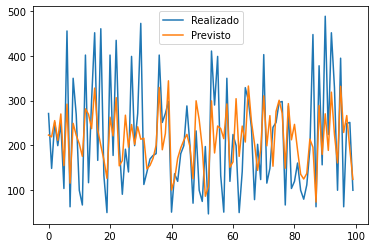

In [14]:
# Exemplo de visualização de dados
results = pd.DataFrame(np.array(y_test).flatten(),columns=['Realizado'])
results['Previsto'] = np.array(y_pred)
results.head(100).plot(kind='line')

## Analisando os registros não rotulados

Agora iremos repetir os passos acima  com os registros não rotulados do projeto, como veremos a seguir.

In [15]:
# Carrega os dados da base não rotulada.
df_test = pd.read_csv(nome_arquivo_sem_rotulos, index_col=None, engine='python', sep =';', encoding="utf-8")
print('Total de registros carregados:',len(df_test))

Total de registros carregados: 3293


In [16]:
df_test.head()

,id,host_name,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,zipcode,latitude,longitude,...,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count
0,4,patricia,within a few hours,100.0,t,t,ipanema,22081-020,-22.98816,-43.19359,...,165,10.0,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,1
1,6,seba,within a day,100.0,f,t,copacabana,22031-112,-22.96681,-43.18657,...,1,0.0,0.0,0.0,0.0,0.0,0.0,f,moderate,1
2,21,andrea,within an hour,85.0,f,f,copacabana,22070-011,-22.98152,-43.19018,...,24,10.0,10.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,6
3,22,diogo,within an hour,100.0,f,f,copacabana,22071-100,-22.98119,-43.19373,...,118,9.0,9.0,10.0,10.0,8.0,8.0,t,strict_14_with_grace_period,1
4,27,josé,within a day,100.0,f,f,copacabana,22031-070,-22.96925,-43.18283,...,20,10.0,8.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,4


In [17]:
# Salvando a coluna 'id', para montar o arquivo de envio ao final da execução.
id_col = df_test['id'] 

In [18]:
# Prepara os dados para classificação.
X_test = preparar_dataset(df_test)
X_test.head()

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count
0,0,100.0,0,0,0,0,0,3,1.5,1.0,...,165,10.0,9.0,10.0,10.0,10.0,9.0,0,0,1
1,1,100.0,1,0,1,0,1,2,1.0,1.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,2,85.0,1,1,1,0,0,4,1.0,1.0,...,24,10.0,10.0,10.0,10.0,9.0,9.0,1,0,6
3,2,100.0,1,1,1,0,0,12,4.0,4.0,...,118,9.0,9.0,10.0,10.0,8.0,8.0,1,0,1
4,1,100.0,1,1,1,0,0,5,2.0,2.0,...,20,10.0,8.0,10.0,10.0,10.0,9.0,0,0,4


In [19]:
# Executa a predição dos registros não rotulados
y_pred = regr.predict(X_test)
df_test['id'] = id_col
df_test['price'] = y_pred
df_test['price'] = df_test['price'].round(decimals=2)

# Exibe uma amostra dos resultados
df_test.head(10)

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,id,price
0,0,100.0,0,0,0,0,0,3,1.5,1.0,...,9.0,10.0,10.0,10.0,9.0,0,0,1,4,187.19
1,1,100.0,1,0,1,0,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,1,1,6,189.56
2,2,85.0,1,1,1,0,0,4,1.0,1.0,...,10.0,10.0,10.0,9.0,9.0,1,0,6,21,222.44
3,2,100.0,1,1,1,0,0,12,4.0,4.0,...,9.0,10.0,10.0,8.0,8.0,1,0,1,22,426.23
4,1,100.0,1,1,1,0,0,5,2.0,2.0,...,8.0,10.0,10.0,10.0,9.0,0,0,4,27,263.01
5,2,100.0,1,0,2,0,0,4,1.0,1.0,...,9.0,10.0,10.0,10.0,9.0,1,0,2,43,234.67
6,2,100.0,1,0,3,0,0,4,1.0,0.0,...,9.0,10.0,10.0,9.0,10.0,1,0,1,46,151.80
7,0,100.0,1,1,1,1,0,6,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,49,318.37
8,0,90.0,1,1,4,2,1,2,0.0,1.0,...,8.0,9.0,9.0,7.0,7.0,0,1,5,55,149.32
9,2,100.0,1,0,5,2,1,2,1.5,1.0,...,10.0,10.0,10.0,10.0,10.0,1,1,4,74,145.44


In [20]:
# Salva os registros classificados
df_test.to_csv(nome_arquivo_rotulado_regressor, index=False, sep=",", encoding="utf-8", columns=['id','price'])

## Submetendo os resultados

O arquivo gerado no passo acima contém os resultados do modelo preditivo. Com ele, podemos ordenar os registros das hospedagens pelo ranking de custo-benefício. Isso permitirá ao usuário priorizar a verificação dos anúncios no site, já com uma indicação dos anúncios mais promissores, permitindo assim uma economia de tempo para realizar essa seleção, assim como uma economia de custo para selecionar uma hospedagem a um valor abaixo do previsto.